In [7]:
import sympy as sy
import random
import numpy as np
from tqdm import tqdm
import math


In [8]:
a, b = sy.symbols('a b')
x = sy.symbols('x')
y = sy.symbols('y')
I = sy.Integral(sy.sin(x)+x+2*x,(x,a,b))
print(sy.pretty(I))

b                  
⌠                  
⎮ (3⋅x + sin(x)) dx
⌡                  
a                  


In [5]:
int_func = sy.integrate(1/((2*math.pi)**(1/2))*sy.exp(-(x**2)/2),x)    #부정적분 생성(적분상수는 0)

# 값 넣어 계산


def p_value(v):
    v = abs(v)
    Fb = int_func.subs(x,10).evalf()         
    Fa = int_func.subs(x,v).evalf()

    return Fb-Fa



In [6]:

    
def check_sensitivity(m, std, trial, sample_size):
    p_values = []
    for i in tqdm(range(trial)) :
        samples = [random.gauss(m, std**2) for i in range(sample_size)]
        mean = np.array(samples).mean()
        p_values.append(p_value(mean))
    
    for h in [0.01, 0.03, 0.05]:
        count = list(np.array(p_values) < h).count(True)
        print(f"({h}): {count}")

for sample_size in range(1, 6):
    print(f"size: {sample_size}")
    check_sensitivity(0, 1, 10000, sample_size)

size: 1


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1090.63it/s]


(0.01): 209
(0.03): 591
(0.05): 1004
size: 2


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1082.49it/s]


(0.01): 9
(0.03): 65
(0.05): 190
size: 3


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1085.81it/s]


(0.01): 1
(0.03): 10
(0.05): 45
size: 4


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1104.09it/s]


(0.01): 0
(0.03): 1
(0.05): 13
size: 5


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1095.80it/s]


(0.01): 0
(0.03): 0
(0.05): 2


In [ ]:
for sample_size in range(1, 6):
    print(f"size: {sample_size}")
    check_sensitivity(0.1, 1, 10000, sample_size)

In [75]:
for sample_size in range(1, 6):
    print(f"size: {sample_size}")
    check_sensitivity(0.3, 1, 10000, sample_size)

size: 1


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1021.45it/s]


(0.01): 265
(0.03): 723
(0.05): 1169
size: 2


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1073.51it/s]


(0.01): 24
(0.03): 123
(0.05): 298
size: 3


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1032.84it/s]


(0.01): 0
(0.03): 35
(0.05): 90
size: 4


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1045.38it/s]


(0.01): 1
(0.03): 15
(0.05): 40
size: 5


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1057.24it/s]


(0.01): 0
(0.03): 0
(0.05): 4


In [361]:
GMM([(-1, 1), (1, 0.1)], [7, 3]).std()

0.703

In [11]:
import matplotlib.pyplot as plt
import numpy as np
int_func = sy.integrate(1/((2*math.pi)**(1/2))*sy.exp(-(x**2)/2),x)    #부정적분 생성(적분상수는 0)

class GMM:
    def __init__(self, gaussians, probability):
        self.gaussians = gaussians
        self.probability = np.array(probability)
        self.probability = list(self.probability/self.probability.sum())
        
    def get_sample(self):
        idx = np.random.choice(list(range(len(self.gaussians))), 1, self.probability).item()
        mean, std = self.gaussians[idx]
        return np.random.normal(mean, std)
    
    def mean(self):
        return np.array([gaussian[0] for gaussian in self.gaussians])@np.array(self.probability)
        
    def std(self):
        return (np.array([gaussian[1] for gaussian in self.gaussians])**2)@np.array(self.probability)
    
# GMM([(-1, 1), (1, 0.1)], [7, 3]).get_sample()

class Env:
    def __init__(self, gmms, trials):
        self.gmms = gmms
        self.trials = trials
        self.gmm_idx_list = sum([[i for x in range(n)] for i, n in enumerate(trials)], [])
        self.idx = -1
        
    def get_sample(self):
        if self.idx == len(self.gmm_idx_list)-1:
            return None
        else:
            self.idx += 1

            return self.gmms[self.gmm_idx_list[self.idx]].get_sample() 

        
    def get_mean_list(self):
        return sum([[self.gmms[i].mean() for x in range(n)] for i, n in enumerate(trials)], [])
        
    def get_std_list(self):
        return sum([[self.gmms[i].std() for x in range(n)] for i, n in enumerate(trials)], [])
    
    def reset(self):
        self.idx = -1
    
def p_value(v):
    v = abs(v)
    Fb = int_func.subs(x,10).evalf()         
    Fa = int_func.subs(x,v).evalf()

    return Fb-Fa

class Model:
    def __init__(self, buffer_size, threshold_smoothing):
        self.mean = 0
        self.variance = 1
        self.short_term_memory = []
        self.short_term_memory_buffer_size = buffer_size
        self.threshold_smoothing = threshold_smoothing
        self.size = 0
        self.size_after_init= 0
        self.min_step_size = 0.001
    def update(self, sample):
        if self.check_change():    
            p = self.short_memory_p_value()
            self.init_long_term_model()
                
        self.short_term_memory.append(sample)
        
        if(self.short_term_memory_buffer_size < len(self.short_term_memory)):
            sample = self.short_term_memory[0]
            self.size += 1
            self.size_after_init += 1
            self.variance += self.step_size()*((sample-self.mean)**2 - self.variance)
            self.mean += self.step_size()*(sample-self.mean)
            del self.short_term_memory[0] 

    def step_size(self):
        return max(self.min_step_size, 1/self.size)
        
    def print_distribution(self):
        print(self.mean, self.variance)
    
    def p_value(self, sample):
        z = (sample - self.mean)/(self.variance**(1/2))
        return p_value(z)
    
    def short_memory_p_value(self):
        sample = np.array(self.short_term_memory).mean()
        return self.p_value(sample)
    
    def check_change(self):
        if self.size == 0:
            return False
        
        p = self.short_memory_p_value()
        threshold = 0.05*min(1, self.size_after_init/self.threshold_smoothing)
        return p<threshold
    
    def init_long_term_model(self):
        self.size = int(self.size/2)
        self.size_after_init = 0


def test(model, env):
    size_list = []
    mean_list = []
    std_list = []
    while True:
        sample = env.get_sample()
        if sample == None:
            break
        model.update(sample)

        size_list.append(model.size)
        mean_list.append(model.mean)
        std_list.append(model.variance**(1/2))
    
    env_mean_list = env.get_mean_list()
    env_std_list = env.get_std_list()
    
#     print(np.array(env_mean_list).size)
#     print(np.array(env_std_list).size)
#     print(np.array(mean_list).size)
#     print(np.array(std_list).size)
    
    smd_list = standardized_mean_difference(np.array(env_mean_list), np.array(env_std_list), np.array(mean_list), np.array(std_list))
    return {"mean_list":mean_list, 
            "std_list":std_list, 
            "size_list":size_list,
           "smd_list":smd_list}

def standardized_mean_difference(m1, s1, m2, s2):
    return abs(m1-m2)/(((s1**2+s2**2)/2)**(1/2))

def show_size_and_smd_graph(size_list, smd_list):
    fig, ax1 = plt.subplots()
    ax1.plot(size_list, label=f"size")

    ax2 = ax1.twinx()
    ax2.set_ylim(0, 5)

    ax2.plot(smd_list, label=f"smd", color="green", linestyle = '--', linewidth = 1)

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

In [22]:
models = [Model(buffer_size=1, threshold_smoothing = 1),
          Model(buffer_size=2, threshold_smoothing = 1),
          Model(buffer_size=3, threshold_smoothing = 1),
          Model(buffer_size=4, threshold_smoothing = 1),
          Model(buffer_size=5, threshold_smoothing = 1)]
gmms = [GMM([(0, 1), (3, 0.1)], [7, 3]),
        GMM([(3, 1), (3, 0.1)], [7, 3]),
        GMM([(2, 1), (10, 0.1)], [7, 3]),
        GMM([(0, 1), (3, 0.1)], [7, 3])]
trials = [500, 500, 500, 500]
envs = [Env(gmms, trials),
        Env(gmms, trials),
        Env(gmms, trials),
        Env(gmms, trials),
        Env(gmms, trials)]

results = [test(model, env) for model, env in tqdm(zip(models, envs))]


0it [00:00, ?it/s]/var/folders/9g/_7xvwk7x3s7786mj9pphty4c0000gn/T/ipykernel_53900/610697680.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.random.choice([(1, 2), 2, 3], 1, [0.2, 0.7, 0.1]).item()

1it [00:01,  1.99s/it]
2it [00:03,  1.96s/it]
3it [00:05,  1.93s/it]
4it [00:07,  1.90s/it]
5it [00:09,  1.91s/it]


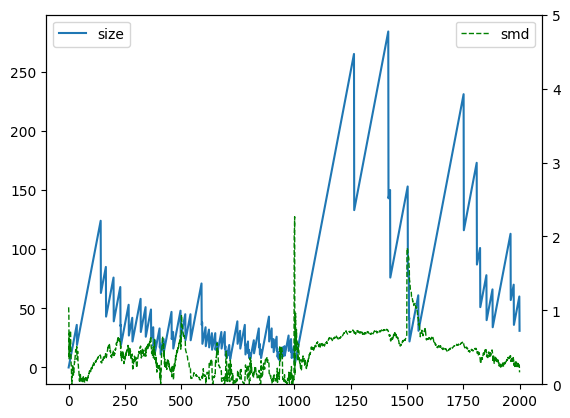

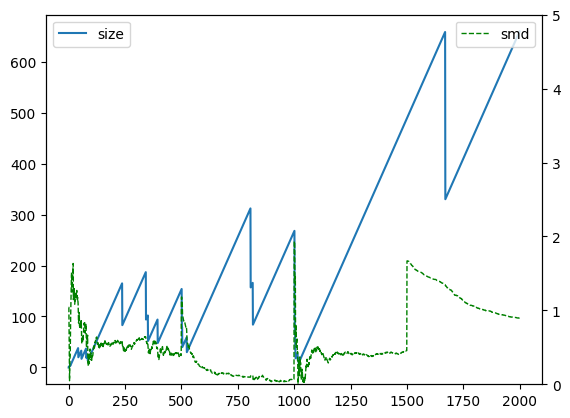

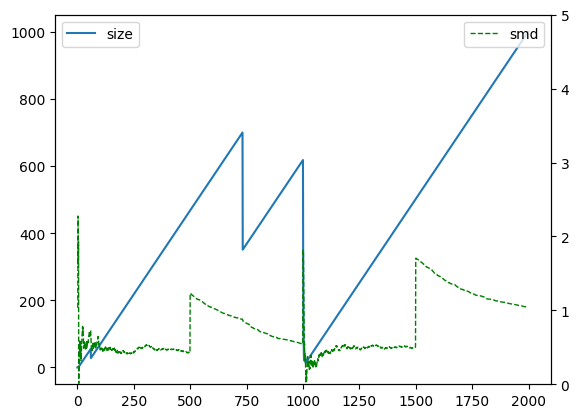

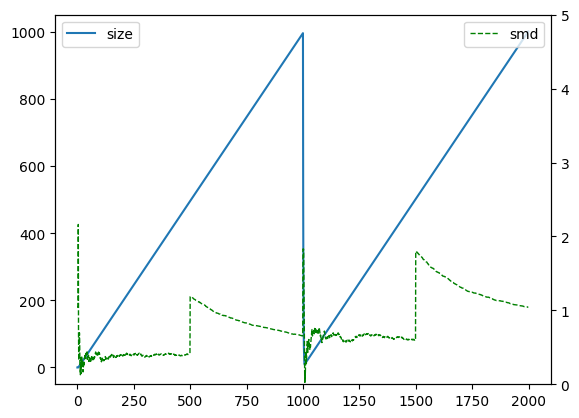

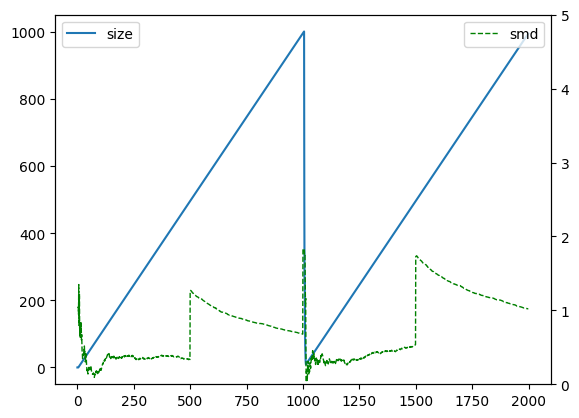

In [23]:
for i in range(5):
    show_size_and_smd_graph(results[i]["size_list"], results[i]["smd_list"])

In [20]:
models = [Model(buffer_size=1, threshold_smoothing = 1),
          Model(buffer_size=2, threshold_smoothing = 1),
          Model(buffer_size=3, threshold_smoothing = 1),
          Model(buffer_size=4, threshold_smoothing = 1),
          Model(buffer_size=5, threshold_smoothing = 1)]
gmms = [GMM([(0, 1)], [1]),
        GMM([(1, 1)], [1]),
        GMM([(3, 1)], [1]),
        GMM([(6, 1)], [1])]
trials = [1000, 1000, 1000, 1000]
envs = [Env(gmms, trials),
        Env(gmms, trials),
        Env(gmms, trials),
        Env(gmms, trials),
        Env(gmms, trials)]

results = [test(model, env) for model, env in tqdm(zip(models, envs))]


0it [00:00, ?it/s]/var/folders/9g/_7xvwk7x3s7786mj9pphty4c0000gn/T/ipykernel_53900/610697680.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.random.choice([(1, 2), 2, 3], 1, [0.2, 0.7, 0.1]).item()

1it [00:04,  4.01s/it]
2it [00:07,  3.89s/it]
3it [00:11,  3.82s/it]
4it [00:15,  3.79s/it]
5it [00:19,  3.80s/it]


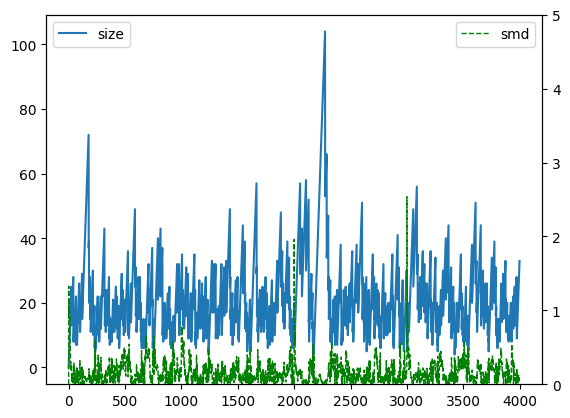

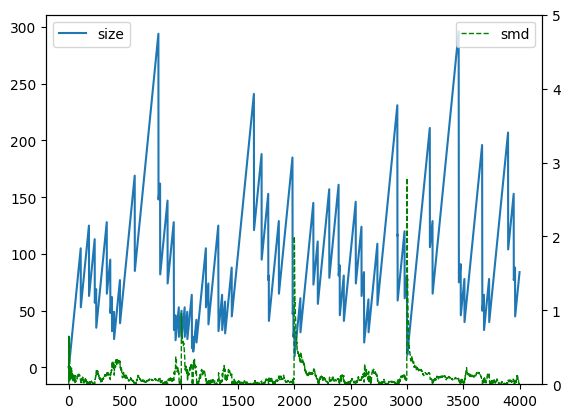

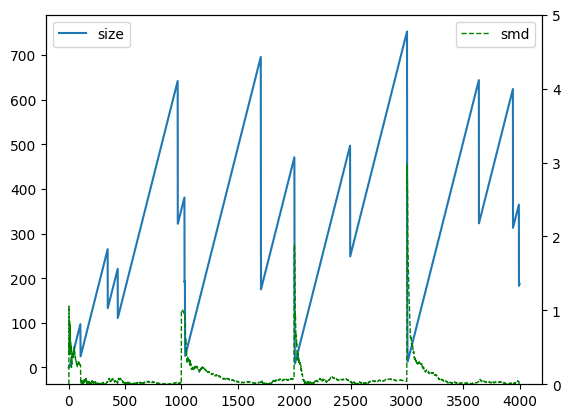

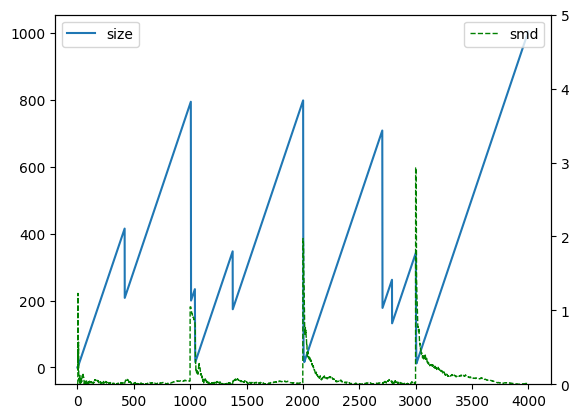

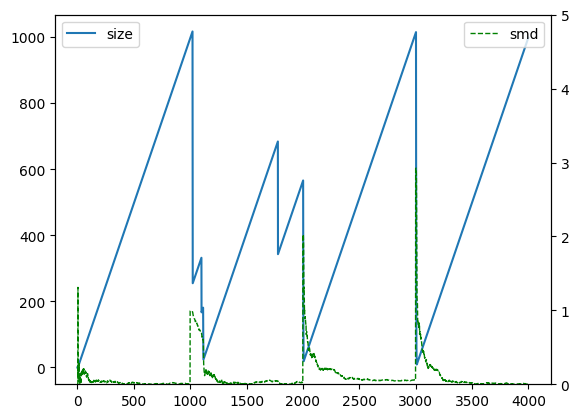

In [21]:
for i in range(5):
    show_size_and_smd_graph(results[i]["size_list"], results[i]["smd_list"])

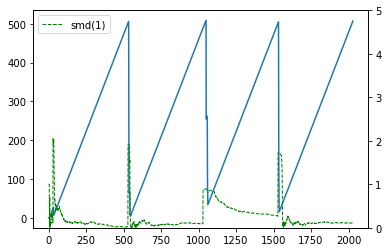

In [250]:
fig, ax1 = plt.subplots()
for i in range(1):
    ax1.plot(size_lists[i-1], label=f"size({i+1})")

ax2 = ax1.twinx()
ax2.set_ylim(0, 5)
for i in range(1):
    ax2.plot(smd_lists[i-1], label=f"smd({i+1})", color="green", linestyle = '--', linewidth = 1)
    
plt.legend(loc="upper left")

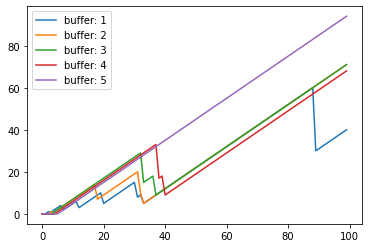

In [120]:
for i in range(1, 6):
    plt.plot(size_lists[i-1][:100], label=f"buffer: {i}")  
plt.legend(loc="upper left")

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 509.67it/s]


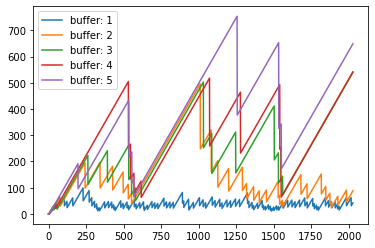

In [121]:
size_lists2 = []
for i in range(1, 6):
    model = Model()
    model.short_term_memory_buffer_size = i
    model.threshold_smoothing = 30
    size_list = test(model, distributions, trials)
    size_lists2.append(size_list)

for i in range(1, 6):
    plt.plot(size_lists2[i-1], label=f"buffer: {i}")  
plt.legend(loc="upper left")

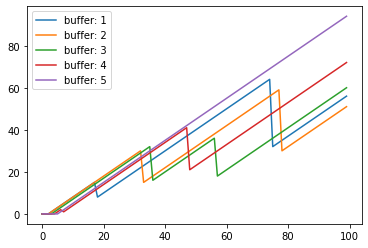

In [122]:
for i in range(1, 6):
    plt.plot(size_lists2[i-1][:100], label=f"buffer: {i}")  
plt.legend(loc="upper left")

0.2317137785453969